In [29]:
import pandas as pd
#from dask.distributed import Client, progress ##For Progress Dashboard
#import dask.dataframe as dd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from ggplot import *
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

In [179]:
Raw_Data = pd.read_csv(r"C:\Users\Selvamani\Desktop\sales_train_validation.csv")
Raw_Data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,...,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,...,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [180]:
##TAKING ONE STORE FOR AGGREGATION
df_Department = Raw_Data.groupby(['dept_id','store_id']).sum().reset_index()
print(df_Department.shape)
df_Department

(70, 1915)


,dept_id,store_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,...,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1,CA_1,297,284,214,175,182,191,224,263,245,176,217,156,242,327,409,446,269,169,164,167,226,301,303,228,160,156,193,238,327,264,177,276,203,216,230,355,283,184,232,204,187,252,354,304,239,186,218,188,266,306,266,239,187,149,161,207,252,218,...,181,375,427,350,295,252,239,278,324,410,462,308,299,215,302,322,496,288,300,222,233,236,328,417,388,295,358,348,335,483,612,411,233,185,215,354,320,311,367,238,246,214,261,319,394,301,257,227,213,282,293,317,268,302,237,287,297,331,419,329
1,FOODS_1,CA_2,406,408,238,240,220,263,304,353,313,272,406,300,354,350,565,542,332,260,272,206,380,379,431,340,220,299,269,324,506,353,212,249,263,278,266,420,390,224,203,222,237,368,390,343,228,179,265,260,233,422,304,209,255,246,222,383,324,382,...,369,432,566,520,368,343,273,382,508,577,633,380,378,362,449,495,671,518,372,328,307,347,427,282,240,408,538,321,457,678,685,528,382,326,274,357,506,491,568,377,283,382,433,464,651,692,422,377,392,375,535,504,515,327,366,422,334,579,623,520
2,FOODS_1,CA_3,341,326,260,231,220,258,285,309,404,290,272,264,346,351,429,625,381,262,276,258,265,492,417,337,222,207,249,264,463,349,261,262,264,264,252,299,436,244,247,223,265,235,332,322,274,266,225,231,217,334,318,269,301,218,211,289,353,340,...,433,479,599,501,375,370,304,494,324,511,534,391,439,421,503,452,523,435,385,334,372,354,354,519,404,364,435,469,347,544,753,527,253,303,330,344,393,385,392,359,336,268,338,464,512,457,422,343,279,289,420,500,457,301,331,306,276,335,510,423
3,FOODS_1,CA_4,113,124,75,97,107,84,100,111,87,66,93,54,80,112,106,131,109,70,75,82,114,118,93,95,96,79,80,79,76,117,96,77,92,84,112,94,138,103,89,103,83,107,82,79,81,98,100,100,105,109,83,104,102,97,118,136,145,103,...,172,273,227,268,192,164,199,190,253,215,243,242,218,210,226,284,256,174,200,220,196,226,280,214,272,220,212,295,327,280,291,281,180,129,198,198,200,207,180,228,191,220,184,229,249,205,199,201,208,191,284,241,193,196,185,201,190,229,250,257
4,FOODS_1,TX_1,152,154,109,126,108,153,72,126,119,95,96,130,177,132,170,196,134,83,120,89,100,142,126,108,93,73,83,96,122,128,135,93,86,102,72,120,174,157,97,111,104,93,135,96,105,124,90,112,116,128,112,105,82,119,110,106,115,123,...,155,200,224,205,175,200,176,191,235,206,242,159,155,178,151,205,229,191,177,190,186,166,161,204,250,148,243,194,195,272,338,357,156,145,149,135,258,263,227,145,199,210,170,233,258,247,171,181,218,165,204,244,245,193,138,176,198,201,218,221
5,FOODS_1,TX_2,210,169,159,107,128,185,169,193,180,176,135,203,213,235,312,553,258,157,168,163,122,179,238,217,144,152,137,128,230,190,108,162,124,114,195,210,231,135,118,140,142,166,175,194,151,147,133,115,181,158,177,149,81,117,124,128,169,169,...,213,270,264,222,153,170,220,254,240,297,273,225,216,212,257,301,297,296,230,193,212,235,235,251,253,247,267,348,270,436,500,362,183,170,223,234,301,255,250,209,224,237,230,215,271,278,179,180,195,218,249,254,249,220,227,221,207,235,280,220
6,FOODS_1,TX_3,138,123,113,84,61,107,96,147,133,97,114,101,141,145,187,265,166,115,82,68,97,114,115,75,73,81,76,103,97,98,100,85,88,96,98,119,133,98,71,89,103,131,149,129,81,81,93,72,130,130,98,83,90,87,75,114,108,90,...,239,257,225,282,241,287,265,331,352,293,248,265,246,233,339,229,226,216,242,266,246,285,259,262,249,232,236,316,328,427,472,413,296,227,207,234,422,305,245,275

In [51]:
df_Category = Raw_Data.groupby(['store_id','cat_id']).sum().reset_index()
Original_Set = df_Category.iloc[1,:]
Original_Set['store_id']

'CA_1'

In [61]:
##TAKING ONE STORE FOR AGGREGATION
##FINDING RATIO CATEGORY WISE
def Category_Final_Ratio(Raw_Data):
    df_Category = Raw_Data.groupby(['store_id','cat_id']).sum().reset_index()
    for i in range(0,df_Category.shape[0]):
        Original_Set = df_Category.iloc[i,:]
        Dividing_Set = df_Category.iloc[i,2:]
        Store_Id = Original_Set['store_id']
        Cat_Id = Original_Set['cat_id']
        Temp_Subset = Raw_Data[(Raw_Data['store_id']== Store_Id) & (Raw_Data['cat_id'] == Cat_Id)]
        Final_df = Temp_Subset.iloc[:,6:].div(Dividing_Set)
        Final_df['store_id'] = Temp_Subset['store_id']
        Final_df['cat_id'] = Temp_Subset['cat_id']
        Final_df['id'] = Temp_Subset['id']
        Final_df.to_csv("C:/Users/Selvamani/Desktop/Master/Category_Ratio.csv",index=False,mode='a',header=False)

In [62]:
Category_Final_Ratio(Raw_Data)

In [184]:
def Department_Final_Ratio(Raw_Data):
    df_Department = Raw_Data.groupby(['dept_id','store_id']).sum().reset_index()
    for i in range(0,df_Department.shape[0]):
        Original_Set = df_Department.iloc[i,:]
        Dividing_Set = df_Department.iloc[i,2:]
        Store_Id = Original_Set['store_id']
        Dept_Id = Original_Set['dept_id']
        Temp_Subset = Raw_Data[(Raw_Data['store_id']== Store_Id) & (Raw_Data['dept_id'] == Dept_Id)]
        Final_df = Temp_Subset.iloc[:,6:].div(Dividing_Set)
        Final_df['store_id'] = Temp_Subset['store_id']
        Final_df['dept_id'] = Temp_Subset['dept_id']
        Final_df['cat_id'] = Temp_Subset['cat_id']
        Final_df['id'] = Temp_Subset['id']
        Final_df.to_csv("C:/Users/Selvamani/Desktop/Master/Department_Ratio.csv",header=False,mode='a',index=False)
Department_Final_Ratio(Raw_Data)

In [185]:
##LOADING RATIO FILES
Department_Final_Ratio = pd.read_csv("C:/Users/Selvamani/Desktop/Master/Department_Ratio.csv",header=None)
Department_Final_Ratio.shape

(30490, 1917)

In [186]:
##CALCULATING MEAN OF DAYS FOR EACH UPC UNDER DEPARTMENT WISE
Means_List = []
for i in range(0,Department_Final_Ratio.shape[0]):
    Means=Department_Final_Ratio.iloc[i,0:1912].mean()
    Means_List.append(Means)
Department_Final_Ratio['Mean_Ratios'] = Means_List
Columns_List =[name for name in range(0,1913)]
Department_Final_Ratio.drop(Columns_List,axis=1,inplace=True)
Department_Final_Ratio.head()

,1913,1914,1915,1916,Mean_Ratios
0,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806
1,CA_1,FOODS_1,FOODS,FOODS_1_002_CA_1_validation,0.001852
2,CA_1,FOODS_1,FOODS,FOODS_1_003_CA_1_validation,0.003013
3,CA_1,FOODS_1,FOODS,FOODS_1_004_CA_1_validation,0.025255
4,CA_1,FOODS_1,FOODS,FOODS_1_005_CA_1_validation,0.004288


In [177]:
Department_Final_Ratio.shape

(12810, 5)

In [187]:
Department_Final_Ratio.columns = ['store_id','dep_id','cat_id','id','Mean_Ratios']
Department_Final_Ratio.head()

,store_id,dep_id,cat_id,id,Mean_Ratios
0,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806
1,CA_1,FOODS_1,FOODS,FOODS_1_002_CA_1_validation,0.001852
2,CA_1,FOODS_1,FOODS,FOODS_1_003_CA_1_validation,0.003013
3,CA_1,FOODS_1,FOODS,FOODS_1_004_CA_1_validation,0.025255
4,CA_1,FOODS_1,FOODS,FOODS_1_005_CA_1_validation,0.004288


In [130]:
##PREDICTIONS
Dept_Predictions = pd.read_csv('C:/Users/Selvamani/Desktop/Master/df_dept_pred_56.csv')
Cat_Predictions = pd.read_csv('C:/Users/Selvamani/Desktop/Master/df_cat_pred_56.csv')
print(Dept_Predictions.shape)
print(Cat_Predictions.shape)


(3920, 5)
(1680, 5)


In [150]:
##FOODS 1680
##HOUSEHOLD 1681 2799
##HOBBIES 2800 3919
df_1 = Dept_Predictions.iloc[0:1680,:]
df_2 = Dept_Predictions.iloc[1680:2800,:]
df_3 = Dept_Predictions.iloc[2800:,:]
df_1['cat_id'] = 'FOODS' 
df_2['cat_id'] = 'HOUSEHOLD'
df_3['cat_id'] = 'HOBBIES'
Final_Dept_Predictions = pd.concat([df_1,df_2,df_3],axis=0)
Final_Dept_Predictions.head()

C:\ProgramData\Anacondanew\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anacondanew\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anacondanew\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

,Unnamed: 0,dept_id,store_id,Date,Forecasted Sales,cat_id
0,0,FOODS_1,CA_1,2016-04-25,883.130723,FOODS
1,1,FOODS_1,CA_1,2016-04-26,757.054867,FOODS
2,2,FOODS_1,CA_1,2016-04-27,416.902936,FOODS
3,3,FOODS_1,CA_1,2016-04-28,443.129626,FOODS
4,4,FOODS_1,CA_1,2016-04-29,769.746746,FOODS


In [112]:
##SANITY CHECK
print(Final_Dept_Predictions.iloc[1670:1680,:])
print(Final_Dept_Predictions.iloc[2790:2800,:])
print(Final_Dept_Predictions.iloc[2800:2810,:])

      Unnamed: 0      dept_id store_id        Date  Forecasted Sales     cat_id
1670        1670      FOODS_3     WI_3  2016-06-10        256.727881      FOODS
1671        1671      FOODS_3     WI_3  2016-06-11        822.804834      FOODS
1672        1672      FOODS_3     WI_3  2016-06-12        760.188373      FOODS
1673        1673      FOODS_3     WI_3  2016-06-13        282.111639      FOODS
1674        1674      FOODS_3     WI_3  2016-06-14        307.495397      FOODS
1675        1675      FOODS_3     WI_3  2016-06-15        382.803737      FOODS
1676        1676      FOODS_3     WI_3  2016-06-16        445.420199      FOODS
1677        1677      FOODS_3     WI_3  2016-06-17        395.495616      FOODS
1678        1678      FOODS_3     WI_3  2016-06-18        583.345001      FOODS
1680        1680  HOUSEHOLD_1     CA_1  2016-04-25        288.227961  HOUSEHOLD
      Unnamed: 0      dept_id store_id        Date  Forecasted Sales     cat_id
2791        2791  HOUSEHOLD_2     WI_3  

In [124]:
Grouped_Depart_Predictions = Final_Dept_Predictions.groupby(['cat_id','store_id','Date']).sum().reset_index()
Grouped_Depart_Predictions.head()

,cat_id,store_id,Date,Unnamed: 0,Forecasted Sales
0,FOODS,CA_1,2016-04-25,1680,1718.544658
1,FOODS,CA_1,2016-04-26,1683,2069.702602
2,FOODS,CA_1,2016-04-27,1686,1151.624772
3,FOODS,CA_1,2016-04-28,1689,1517.160461
4,FOODS,CA_1,2016-04-29,1692,1516.317528


In [149]:
##MERGING DATAFRAME 
Mean_Forecasted_DF = pd.merge(left=Cat_Predictions,right=Grouped_Depart_Predictions,how='inner',on=['cat_id','store_id','Date'])
Mean_Forecasted_DF['Mean_Forecast'] = (Mean_Forecasted_DF['Forecasted Sales_x']+Mean_Forecasted_DF['Forecasted Sales_y'])/2
Mean_Forecasted_DF.shape()

,Unnamed: 0_x,cat_id,store_id,Date,Forecasted Sales_x,Unnamed: 0_y,Forecasted Sales_y,Mean_Forecast
0,0,FOODS,CA_1,2016-04-25,2245.128021,1680,1718.544658,1981.836339
1,1,FOODS,CA_1,2016-04-26,408.139994,1683,2069.702602,1238.921298
2,2,FOODS,CA_1,2016-04-27,2185.897593,1686,1151.624772,1668.761182
3,3,FOODS,CA_1,2016-04-28,437.755208,1689,1517.160461,977.457834
4,4,FOODS,CA_1,2016-04-29,2156.282379,1692,1516.317528,1836.299954


In [176]:
Mean_Forecasted_DF.shape

(1680, 8)

In [188]:
##MERGING RATIODATAFRAME AND MEAN_FORECASTED_DF
Multiplied_Dataframe = pd.merge(right=Mean_Forecasted_DF,left=Department_Final_Ratio,how='inner',on=['store_id','cat_id'])
Multiplied_Dataframe.head()
Multiplied_Dataframe['Final_Forecast'] = Multiplied_Dataframe['Mean_Ratios'] * Multiplied_Dataframe['Mean_Forecast']
print(Multiplied_Dataframe.shape)
Multiplied_Dataframe.head()

(1707440, 12)


,store_id,dep_id,cat_id,id,Mean_Ratios,Unnamed: 0_x,Date,Forecasted Sales_x,Unnamed: 0_y,Forecasted Sales_y,Mean_Forecast,Final_Forecast
0,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806,0,2016-04-25,2245.128021,1680,1718.544658,1981.836339,5.561632
1,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806,1,2016-04-26,408.139994,1683,2069.702602,1238.921298,3.476788
2,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806,2,2016-04-27,2185.897593,1686,1151.624772,1668.761182,4.683049
3,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806,3,2016-04-28,437.755208,1689,1517.160461,977.457834,2.743042
4,CA_1,FOODS_1,FOODS,FOODS_1_001_CA_1_validation,0.002806,4,2016-04-29,2156.282379,1692,1516.317528,1836.299954,5.153213


In [204]:
Final_Submission = pd.DataFrame()
Final_Submission['id'] = Multiplied_Dataframe['id']
Final_Submission['Date'] =  Multiplied_Dataframe['Date']
Final_Submission['Final_Forecast'] = Multiplied_Dataframe['Final_Forecast']
Final_Submission.to_csv("C:/Users/Selvamani/Desktop/Master/Submission.csv",index=False)
print(Final_Submission.shape)
Final_Submission.head()

(1707440, 3)


,id,Date,Final_Forecast
0,FOODS_1_001_CA_1_validation,2016-04-25,5.561632
1,FOODS_1_001_CA_1_validation,2016-04-26,3.476788
2,FOODS_1_001_CA_1_validation,2016-04-27,4.683049
3,FOODS_1_001_CA_1_validation,2016-04-28,2.743042
4,FOODS_1_001_CA_1_validation,2016-04-29,5.153213


In [205]:
Final_Submission = Final_Submission.pivot(index='id',columns='Date')

In [291]:
sample_submission_01 = pd.DataFrame()
sample_submission_02 = pd.DataFrame()
sample_submission_01['id'] = Final_Submission.index
sample_submission_02['id'] = Final_Submission.index
Temp_01 = Final_Submission['Final_Forecast'].iloc[:,0:28]
Temp_02 = Final_Submission['Final_Forecast'].iloc[:,28:]
sample_submission_01 = pd.merge(left=sample_submission_01,right=Temp_01,on=['id'],how='right')
sample_submission_02 = pd.merge(left=sample_submission_02,right = Temp_02 ,on=['id'],how='right')
print(sample_submission_01.shape)
print(sample_submission_02.shape)

(30490, 29)
(30490, 29)


In [295]:
Columns_Final_List = ['F{0}'.format(i) for i in range(0,29)]
sample_submission_01.columns=Columns_Final_List
sample_submission_02.columns=Columns_Final_List
Submission_File = pd.concat([sample_submission_01,sample_submission_02],axis=0,ignore_index=True)
Submission_File = Submission_File.rename(columns={'F0':'id'})
sample_submission = pd.read_csv(r"C:\Users\Selvamani\Desktop\sample_submission.csv")
Submission_File['id'] = sample_submission['id']
Submission_File.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,FOODS_3_823_WI_3_evaluation,3.001769,2.281969,1.667840,1.772205,1.519117,1.362560,1.952558,2.378177,1.868415,1.266678,1.399094,2.122808,2.466760,2.694734,2.947173,2.789317,2.739745,1.200989,2.098867,1.253828,2.310213,2.841499,1.504304,2.434798,2.523832,1.927313,2.468388,1.790665
60976,FOODS_3_824_WI_3_evaluation,1.535509,1.021901,1.150979,0.792180,1.017963,1.019623,0.796746,1.752988,1.188747,1.829769,1.363478,0.659785,1.599423,1.724351,0.761468,1.368874,0.618221,0.838191,1.349098,1.166690,1.793187,1.354705,1.658299,0.774690,1.160466,1.203214,1.412184,1.408447
60977,FOODS_3_825_WI_3_evaluation,1.085917,0.755871,1.123666,0.803620,1.093339,0.661341,1.277882,0.608430,0.795069,1.062850,0.856045,0.442275,1.254329,0.728771,1.271430,1.156251,0.715865,0.828622,0.910249,0.467120,0.587193,0.934822,1.292778,1.079686,0.466529,1.336979,0.525248,0.775767
60978,FOODS_3_826_WI_3_evaluation,0.229893,0.290843,0.410669,0.428840,0.367532,0.585721,0.326469,0.274818,0.590587,0.374400,0.242054,0.375185,0.509032,0.249780,0.349504,0.537505,0.621777,0.395073,0.618200,0.364671,0.389636,0.477199,0.433132,0.567980,0.324681,0.459673,0.553744,0.329402
60979,FOODS_3_827_WI_3_evaluation,2.114154,2.096649,2.043643,2.033917,2.096648,2.194880,1.968269,2.132148,1.883654,2.133609,1.842079,1.557599,1.109000,1.489520,1.359194,1.725370,1.570731,1.618874,1.630545,1.440163,1.321510,1.109487,1.258778,1.328318,1.376461,1.171247,1.942257,1.120672


In [293]:
print(sample_submission_New.shape)
print(Submission_File.shape)

(60980, 1)
(60980, 29)


In [296]:
Submission_File.to_csv("C:/Users/Selvamani/Desktop/Master/sample_submission.csv",index=False)

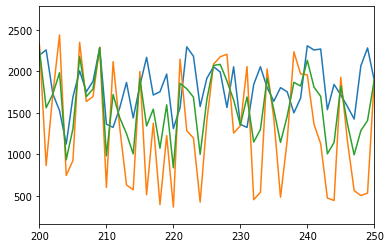

In [129]:
##SANITY CHECK of Mean FORECAST
plt.xlim(200,250)
plt.plot(Grouped_Depart_Predictions['Forecasted Sales'])
plt.plot(Cat_Predictions['Forecasted Sales'])
plt.plot(Mean_Forecasted_DF['Mean_Forecast'])
plt.show()

In [4]:
##FINAL MODELLING
Final_Csv = pd.read_csv(r"C:\Users\Selvamani\Desktop\df_foods.csv")
Final_Csv.drop(['Unnamed: 0'],axis=1,inplace=True)
Final_Csv.head()

,cat_id,store_id,Date,dayofyear,weekofyear,monthstart,quarterstart,yearstart,Sales
0,FOODS,CA_1,2011-01-29,29,4,0,0,0,3239
1,FOODS,CA_1,2011-01-30,30,4,0,0,0,3137
2,FOODS,CA_1,2011-01-31,31,5,0,0,0,2008
3,FOODS,CA_1,2011-02-01,32,5,1,0,0,2258
4,FOODS,CA_1,2011-02-02,33,5,0,0,0,2032


In [6]:
df_foods=Final_Csv[['store_id','Date','Sales']]
df_foods.columns=['store_id','ds','y']
stores={'CA_1':1,'CA_2':2,'CA_3':3,'CA_4':4,'TX_1':5,'TX_2':6,'TX_3':7,'WI_1':8,'WI_2':9,'WI_3':10}
df_foods['store_id']=df_foods['store_id'].map(stores)
print(df_foods.tail())

C:\ProgramData\Anacondanew\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



       store_id          ds     y
19125        10  2016-04-20  2232
19126        10  2016-04-21  2308
19127        10  2016-04-22  2665
19128        10  2016-04-23  3240
19129        10  2016-04-24  3107


In [7]:
print('entering model')
fb = Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True)
fb.add_country_holidays(country_name='US')
fb.add_regressor('store_id')
fb.fit(df_foods)

entering model


C:\ProgramData\Anacondanew\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anacondanew\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [21]:
future = fb.make_future_dataframe(freq='D', periods=28,include_history=False)
print(future.tail())
a=pd.Series([1,2,3,4,5,6,7,8,9,10])
stores1=pd.DataFrame({'store_id':a.repeat(28)}).reset_index()
print(stores1.tail())
future['store_id']=stores1['store_id']
print(future.tail())

           ds
23 2016-05-18
24 2016-05-19
25 2016-05-20
26 2016-05-21
27 2016-05-22
     index  store_id
275      9        10
276      9        10
277      9        10
278      9        10
279      9        10
           ds  store_id
23 2016-05-18         1
24 2016-05-19         1
25 2016-05-20         1
26 2016-05-21         1
27 2016-05-22         1


In [26]:
Final_DF = pd.concat([future]*10).reset_index()
Final_DF.drop('index',axis=1,inplace=True)
Final_DF['store_id'] = stores1['store_id']
Final_DF

,ds,store_id
0,2016-04-25,1
1,2016-04-26,1
2,2016-04-27,1
3,2016-04-28,1
4,2016-04-29,1
5,2016-04-30,1
6,2016-05-01,1
7,2016-05-02,1
8,2016-05-03,1
9,2016-05-04,1


In [27]:
predict = fb.predict(Final_DF)
print(predict)

            ds        trend   yhat_lower  ...  multiplicative_terms_lower  multiplicative_terms_upper         yhat
0   2016-04-25  2765.055635  1220.851504  ...                         0.0                         0.0  2771.386445
1   2016-04-25  2765.055635   827.742533  ...                         0.0                         0.0  2430.465759
2   2016-04-25  2765.055635  1232.460374  ...                         0.0                         0.0  2695.626292
3   2016-04-25  2765.055635  1004.874987  ...                         0.0                         0.0  2657.746216
4   2016-04-25  2765.055635   861.463150  ...                         0.0                         0.0  2468.345835
5   2016-04-25  2765.055635   858.760141  ...                         0.0                         0.0  2506.225911
6   2016-04-25  2765.055635  1076.560791  ...                         0.0                         0.0  2581.986064
7   2016-04-25  2765.055635  1195.819104  ...                         0.0       